In [33]:
from IPython.display import display, HTML

display(HTML("""
<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/ABUALHUSSEIN/Predicting-Optimal-Fertilizers/main/Predicting_Optimal_Fertilizers.jpeg
" width="1000">
</div>
"""))


 # Step 1: Understand the Dataset

🎯Objective: Predict the best fertilizer to use based on:

'Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type', 'Nitrogen', 'Potassium', 'Phosphorous' input features.


# Step 2: Load & Explore the Data


In [34]:
import os
import json

# Create the .kaggle folder
os.makedirs("/root/.kaggle", exist_ok=True)

# Paste your Kaggle API token here as a Python dictionary
kaggle_token = {
    "username": "wafaaalayoubi",
    "key": "ae0b2c7d96ce9ad79c07dbbb3ce30055"
}

# Save it to the correct location
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_token, f)

# Set correct file permissions
os.chmod("/root/.kaggle/kaggle.json", 600)


In [35]:
!kaggle competitions download -c playground-series-s5e6
!unzip playground-series-s5e6.zip

playground-series-s5e6.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  playground-series-s5e6.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [103]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import classification_report

In [88]:
df_train = pd.read_csv("train.csv")
df_train.head()

id  Temparature  Humidity  Moisture Soil Type  Crop Type  Nitrogen  \
0   0           37        70        36    Clayey  Sugarcane        36   
1   1           27        69        65     Sandy    Millets        30   
2   2           29        63        32     Sandy    Millets        24   
3   3           35        62        54     Sandy     Barley        39   
4   4           35        58        43       Red      Paddy        37   

   Potassium  Phosphorous Fertilizer Name  
0          4            5           28-28  
1          6           18           28-28  
2         12           16        17-17-17  
3         12            4        10-26-26  
4          2           16             DAP

In [89]:
df_test = pd.read_csv("test.csv")
df_test.head()

id  Temparature  Humidity  Moisture Soil Type    Crop Type  Nitrogen  \
0  750000           31        70        52     Sandy        Wheat        34   
1  750001           27        62        45       Red    Sugarcane        30   
2  750002           28        72        28    Clayey  Ground Nuts        14   
3  750003           37        53        57     Black  Ground Nuts        18   
4  750004           31        55        32       Red       Pulses        13   

   Potassium  Phosphorous  
0         11           24  
1         14           15  
2         15            4  
3         17           36  
4         19           14

In [39]:
column_names = df_train.columns.tolist()
print(column_names)

['id', 'Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type', 'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name']


In [40]:
print(df_train.shape)

(750000, 10)



The dataset has  750,000 rows and 10 columns (9 features + 1 target).

In [41]:
# Check the data types and memory usage
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               750000 non-null  int64 
 1   Temparature      750000 non-null  int64 
 2   Humidity         750000 non-null  int64 
 3   Moisture         750000 non-null  int64 
 4   Soil Type        750000 non-null  object
 5   Crop Type        750000 non-null  object
 6   Nitrogen         750000 non-null  int64 
 7   Potassium        750000 non-null  int64 
 8   Phosphorous      750000 non-null  int64 
 9   Fertilizer Name  750000 non-null  object
dtypes: int64(7), object(3)
memory usage: 57.2+ MB


The Predicting Optimal Fertilizers dataset includes the following key features:


| Feature Name      | Type                   | Description                                                    |
|-------------------|------------------------|----------------------------------------------------------------|
| id                | Integer                | Unique identifier for each sample                              |
| Temparature       | Integer                | Ambient temperature (likely in Celsius)                        |
| Humidity          | Integer                | Relative humidity (%)                                          |
| Moisture          | Integer                | Soil moisture level (unit not specified)                       |
| Soil Type         | Categorical            | Type of soil (e.g., Sandy, Clayey, Red...)                     |
| Crop Type         | Categorical            | Type of crop being grown (e.g., Paddy, Millets...)            |
| Nitrogen          | Integer                | Nitrogen content in the soil                                   |
| Potassium         | Integer                | Potassium content in the soil                                  |
| Phosphorous       | Integer                | Phosphorous content in the soil                                |
| Fertilizer Name   | Categorical (Target)   | Label – Best fertilizer for the conditions (e.g., "14-35-14")  |



Features:

* Temparature, Humidity, Moisture (numerical, weather-related)

* Soil Type, Crop Type (categorical)

* Nitrogen, Potassium, Phosphorous (numerical, soil nutrients)

Target: Fertilizer Name (categorical, like 28-28, DAP, Urea, etc.)

### Drop ID column  offers no information to model

In [90]:
# Save test IDs before dropping
test_ids = df_test['id'].copy()

In [91]:
# Drop 'id' column from both
df_train.drop(columns=['id'], inplace=True)
df_test.drop(columns=['id'], inplace=True)

In [92]:
df_train.head()

Temparature  Humidity  Moisture Soil Type  Crop Type  Nitrogen  Potassium  \
0           37        70        36    Clayey  Sugarcane        36          4   
1           27        69        65     Sandy    Millets        30          6   
2           29        63        32     Sandy    Millets        24         12   
3           35        62        54     Sandy     Barley        39         12   
4           35        58        43       Red      Paddy        37          2   

   Phosphorous Fertilizer Name  
0            5           28-28  
1           18           28-28  
2           16        17-17-17  
3            4        10-26-26  
4           16             DAP

# 📊 Step 3: Exploratory Data Analysis (EDA)


## Check for missing values:

In [45]:
# Check for missing values in the dataset
missing_values = df_train.isnull().sum()

print(missing_values)

Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64


In [46]:
# Display only features with missing values (if any)
missing_values = missing_values[missing_values > 0]

if missing_values.empty:
    print("✅ No missing values found in the training dataset.")
else:
    print("⚠️ Missing values detected:\n", missing_values)


✅ No missing values found in the training dataset.



## Check for Duplicates:


In [47]:
# Count duplicate rows in the entire DataFrame
duplicate_count = df_train.duplicated().sum()
print("Number of duplicate records:", duplicate_count)


Number of duplicate records: 0


# Check the numerical data

In [48]:

df_train.describe()


Temparature       Humidity       Moisture       Nitrogen  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean       31.503565      61.038912      45.184147      23.093808   
std         4.025574       6.647695      11.794594      11.216125   
min        25.000000      50.000000      25.000000       4.000000   
25%        28.000000      55.000000      35.000000      13.000000   
50%        32.000000      61.000000      45.000000      23.000000   
75%        35.000000      67.000000      55.000000      33.000000   
max        38.000000      72.000000      65.000000      42.000000   

           Potassium    Phosphorous  
count  750000.000000  750000.000000  
mean        9.478296      21.073227  
std         5.765622      12.346831  
min         0.000000       0.000000  
25%         4.000000      10.000000  
50%         9.000000      21.000000  
75%        14.000000      32.000000  
max        19.000000      42.000000

Summary statistics for all object (categorical/text) columns in the DataFrame df_train.

 ## Next Step: Explore Categorical Columns

We’ll now check the unique values of:

* Soil Type

* Crop Type

* Fertilizer Name (target variable)

Then we’ll visualize their distributions

In [49]:
df_train.describe(include='O')

Soil Type Crop Type Fertilizer Name
count     750000    750000          750000
unique         5        11               7
top        Sandy     Paddy        14-35-14
freq      156710     85754          114436

 Check Unique Classes in Target
Understand how many fertilizer classes we're predicting

In [50]:
df_train['Fertilizer Name'].value_counts()

Fertilizer Name
14-35-14    114436
10-26-26    113887
17-17-17    112453
28-28       111158
20-20       110889
DAP          94860
Urea         92317
Name: count, dtype: int64

## Visualize the target (Fertilizer Name) distribution:

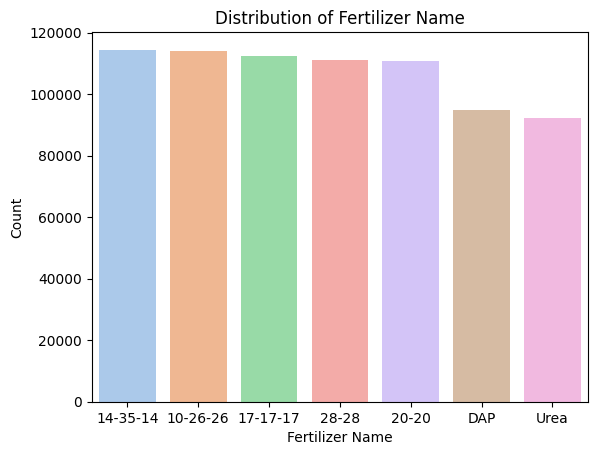

In [51]:

# Create a value count DataFrame so we can assign categories
fertilizer_counts = df_train['Fertilizer Name'].value_counts().reset_index()
fertilizer_counts.columns = ['Fertilizer Name', 'Count']

# Plot using hue for coloring
sns.barplot(data=fertilizer_counts, x='Fertilizer Name', y='Count', hue='Fertilizer Name', palette='pastel', dodge=False)
plt.xlabel('Fertilizer Name')
plt.ylabel('Count')
plt.title('Distribution of Fertilizer Name')
plt.legend([],[], frameon=False)  # Remove redundant legend
plt.show()


In [52]:
# Calculate class distribution
class_dist = df_train['Fertilizer Name'].value_counts(normalize=True).mul(100).round(2)

# Convert to a DataFrame for table output
table = pd.DataFrame({
    'Fertilizer Name': class_dist.index,
    'Proportion (%)': class_dist.values
})

# Print the table nicely
print(table.to_string(index=False))


Fertilizer Name  Proportion (%)
       14-35-14           15.26
       10-26-26           15.18
       17-17-17           14.99
          28-28           14.82
          20-20           14.79
            DAP           12.65
           Urea           12.31


 Conclusion: Is the Data Imbalanced?

Mostly balanced: The top 5 classes are all within ~0.5% of each other.

Mild imbalance: DAP and Urea are ~2.5–3% lower than the top classes.

🔍 This is not severe imbalance — but it’s worth monitoring


In [53]:
# Check unique Soil types
df_train['Soil Type'].value_counts()

Soil Type
Sandy     156710
Black     150956
Clayey    148382
Red       148102
Loamy     145850
Name: count, dtype: int64

## Visualize the Soil Type distribution:

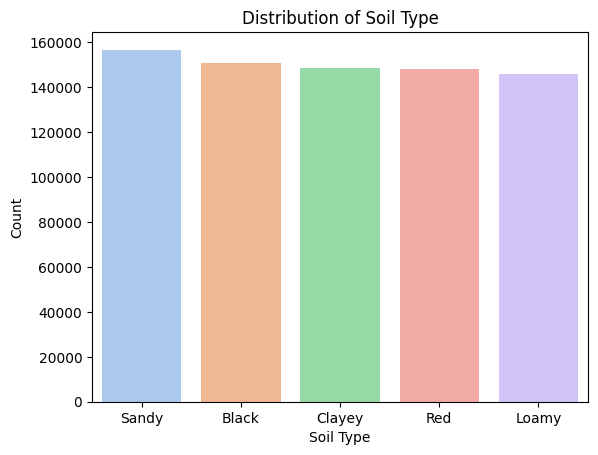

In [54]:

# Create a value count DataFrame so we can assign categories
fertilizer_counts = df_train['Soil Type'].value_counts().reset_index()
fertilizer_counts.columns = ['Soil Type', 'Count']

# Plot using hue for coloring
sns.barplot(data=fertilizer_counts, x='Soil Type', y='Count', hue='Soil Type', palette='pastel', dodge=False)
plt.xlabel('Soil Type')
plt.ylabel('Count')
plt.title('Distribution of Soil Type')
plt.legend([],[], frameon=False)  # Remove redundant legend
plt.show()


 ### Soil Types
Fairly balanced, with Sandy being the most common and Loamy the least.

In [55]:
# Check unique Soil types
df_train['Crop Type'].value_counts()

Crop Type
Paddy          85754
Pulses         78180
Cotton         69171
Tobacco        68000
Wheat          66628
Millets        65291
Barley         65045
Sugarcane      64269
Oil seeds      64184
Maize          62569
Ground Nuts    60909
Name: count, dtype: int64

## Visualize the Crop Type distribution:

/tmp/ipython-input-56-452290347.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=crop_counts, x='Crop Type', y='Count', palette='pastel')


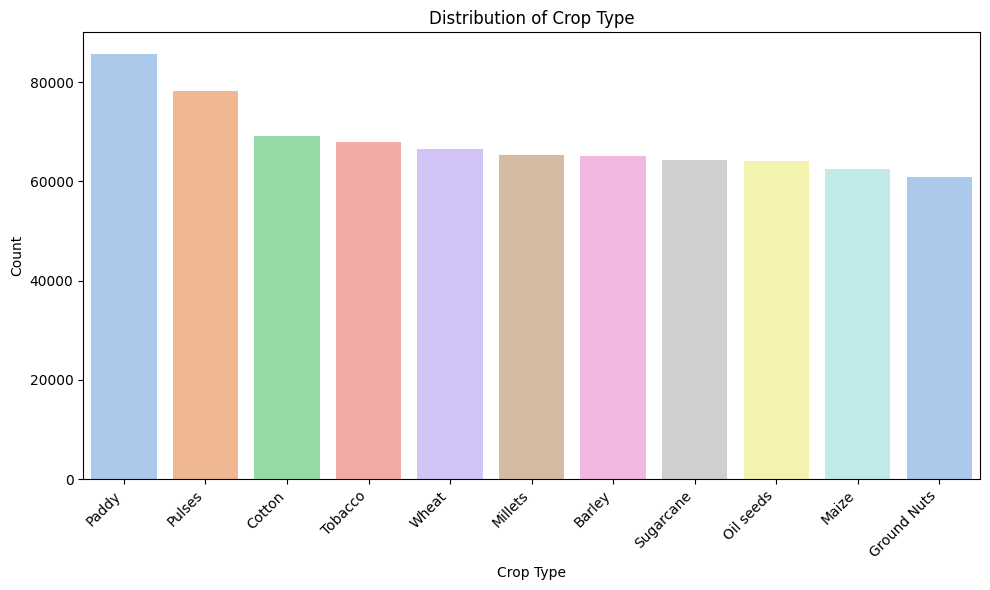

In [56]:

# Count crop types and sort them by frequency
crop_counts = df_train['Crop Type'].value_counts().reset_index()
crop_counts.columns = ['Crop Type', 'Count']

# Sort for better visual order
crop_counts = crop_counts.sort_values(by='Count', ascending=False)

# Plot without hue, sorted and rotated
plt.figure(figsize=(10, 6))
sns.barplot(data=crop_counts, x='Crop Type', y='Count', palette='pastel')

# Rotate x-axis labels to avoid clutter
plt.xticks(rotation=45, ha='right')

# Add title and labels
plt.xlabel('Crop Type')
plt.ylabel('Count')
plt.title('Distribution of Crop Type')
plt.tight_layout()
plt.show()


### Crop Types

Reasonably balanced too, though Paddy and Pulses have higher representation.

All 11 crop categories have substantial data.

### Pairplots

A pairplot is a graph that shows relationships between multiple variables in a dataset.

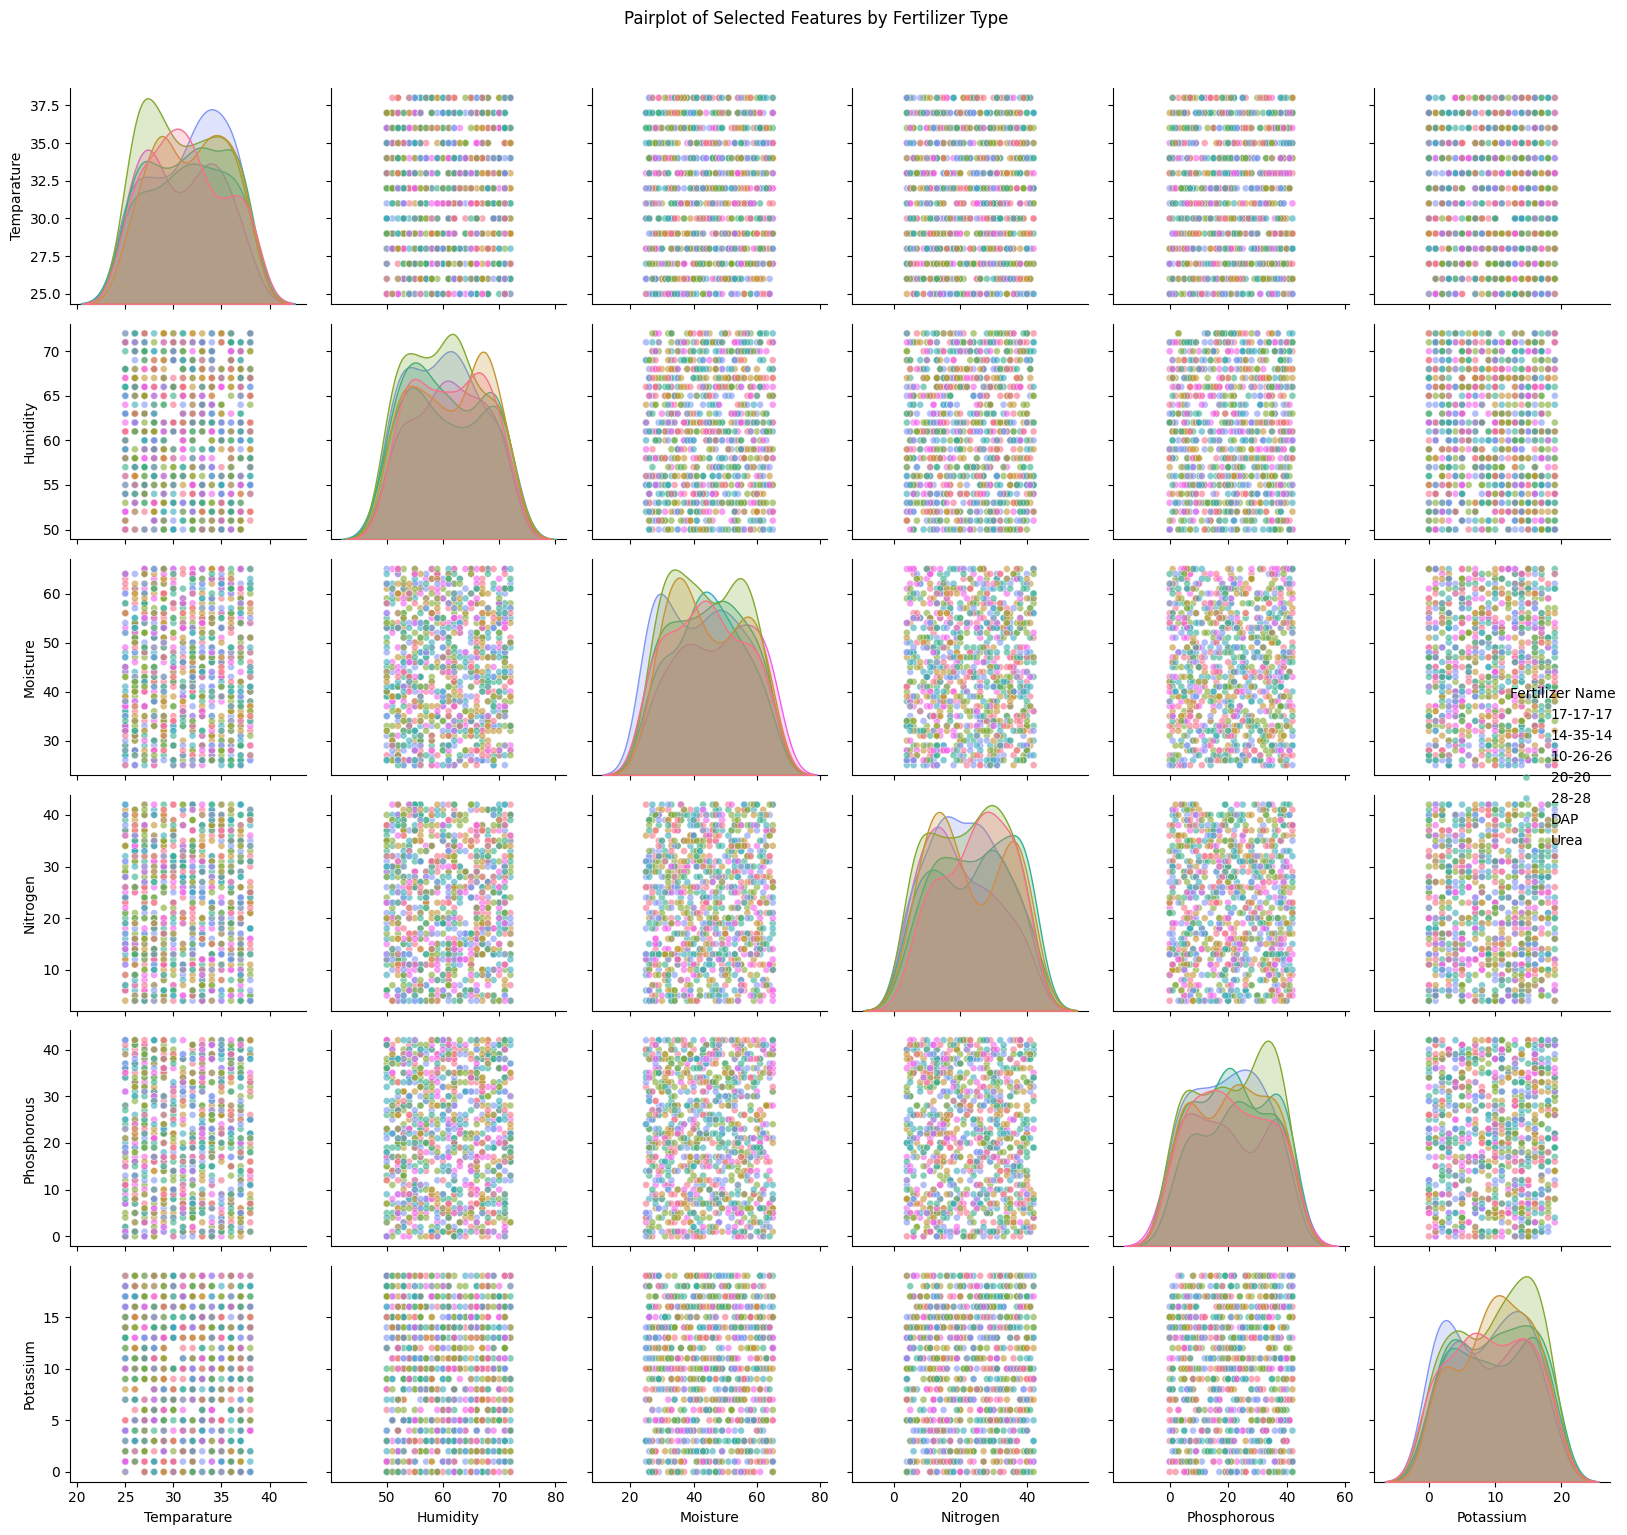

In [57]:

# Sample only a subset if dataset is large
sample_df = df_train.sample(n=1000, random_state=42)

# Plot pairplot of selected numerical features
sns.pairplot(sample_df,
             vars=[
                 'Temparature',
                 'Humidity',
                 'Moisture',
                 'Nitrogen',
                 'Phosphorous',
                 'Potassium'
             ],
             hue='Fertilizer Name',
             palette='husl',
             plot_kws={'alpha': 0.6, 's': 25},
             diag_kind='kde')

plt.suptitle("Pairplot of Selected Features by Fertilizer Type", y=1.02)
plt.tight_layout()
plt.show()


In [58]:
numeric_features = [
    'Temparature',  # assuming it's spelled like this in your dataset
    'Humidity',
    'Moisture',
    'Nitrogen',
    'Phosphorous',
    'Potassium'
]


In [59]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_train[numeric_features])


/tmp/ipython-input-60-3472603093.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


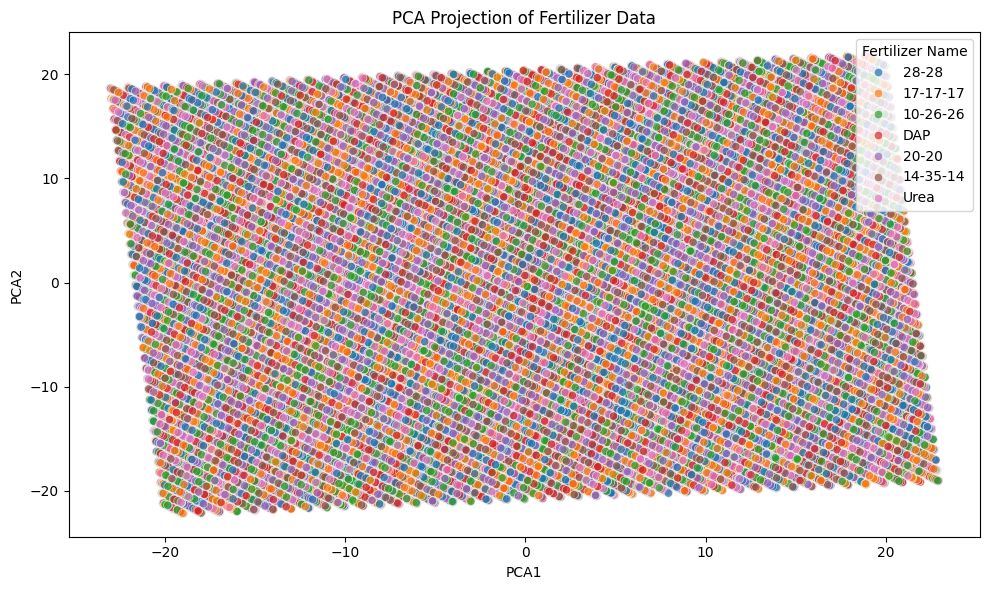

In [60]:
# Add PCA results back to the DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['Fertilizer Name'] = df_train['Fertilizer Name'].values

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Fertilizer Name', palette='tab10', alpha=0.7)
plt.title('PCA Projection of Fertilizer Data')
plt.tight_layout()
plt.show()


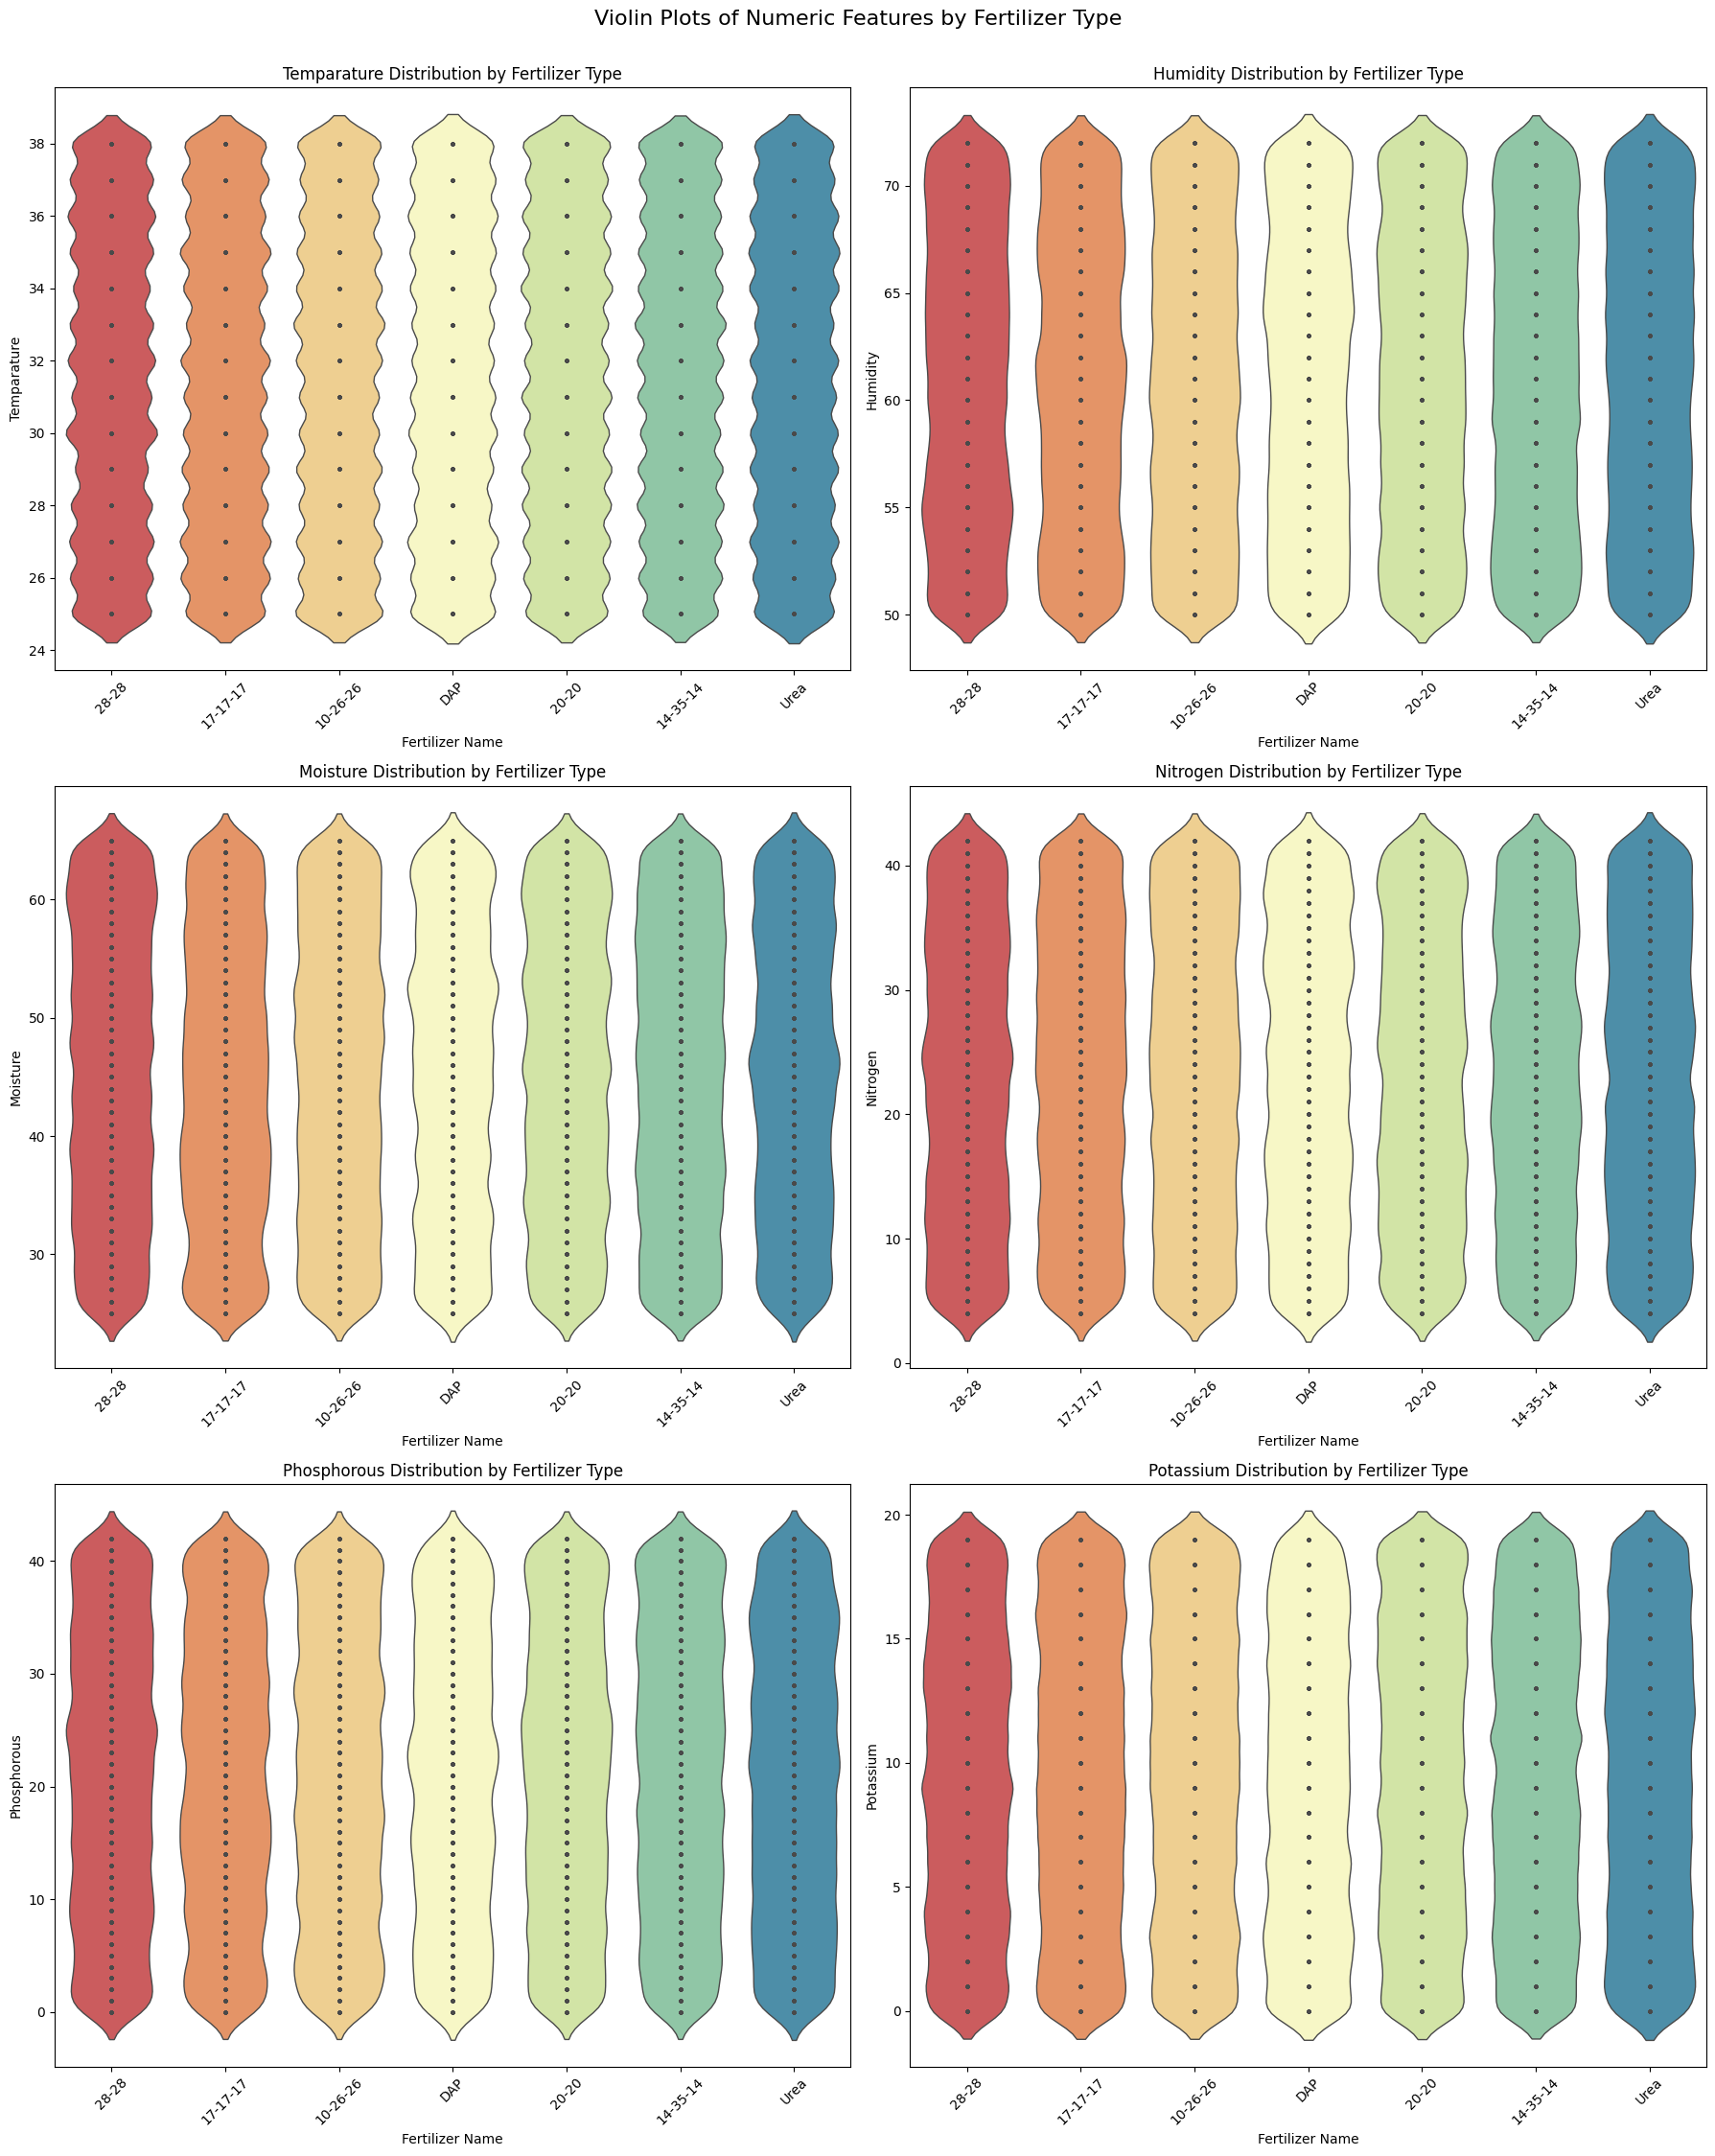

In [61]:
# List of numeric features
numeric_features = [
    'Temparature', 'Humidity', 'Moisture',
    'Nitrogen', 'Phosphorous', 'Potassium'
]

# Plot
plt.figure(figsize=(18, 22))

for i, feature in enumerate(numeric_features):
    plt.subplot(3, 2, i + 1)

    sns.violinplot(
        data=df_train,
        x='Fertilizer Name',
        y=feature,
        hue='Fertilizer Name',   # <== ✅ ADD THIS
        palette='Spectral',
        inner='point',           # Show median
        linewidth=1,
        legend=False             # <== ✅ PREVENTS DUPLICATE LEGEND
    )

    plt.title(f'{feature} Distribution by Fertilizer Type', fontsize=12)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle("Violin Plots of Numeric Features by Fertilizer Type", fontsize=16, y=1.02)
plt.show()


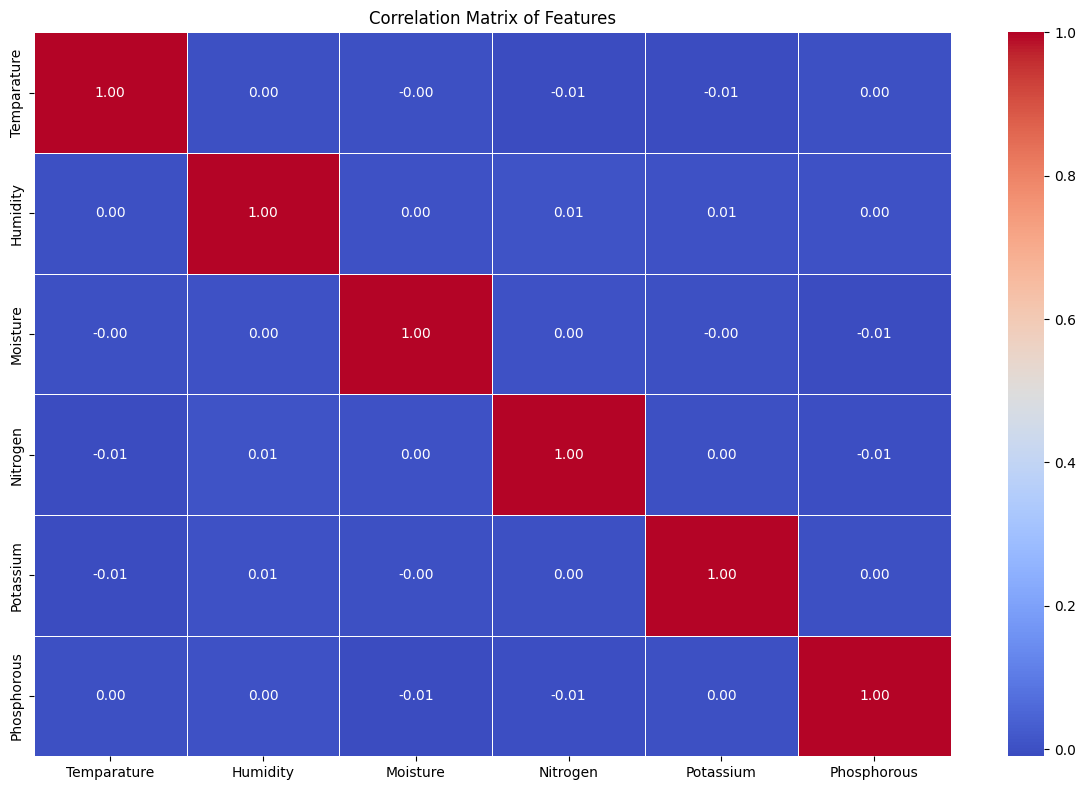

In [62]:
# Compute the correlation matrix (numeric columns only)
corr = df_train.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.show()

/tmp/ipython-input-63-2354472552.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cor_with_target.index, y=cor_with_target.values, palette='viridis')


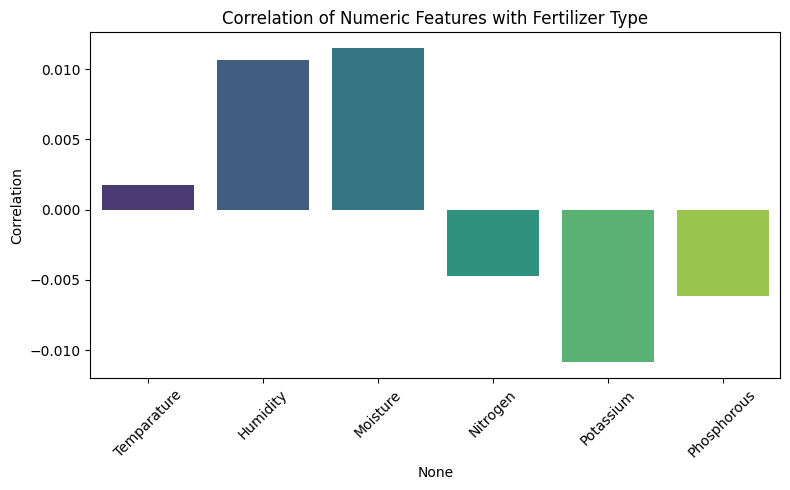

In [63]:
# Encode Fertilizer Name to numeric codes
df_encoded = df_train.copy()
df_encoded['Fertilizer_Code'] = LabelEncoder().fit_transform(df_encoded['Fertilizer Name'])

# Get correlation of features with target
cor_with_target = df_encoded.corr(numeric_only=True)['Fertilizer_Code'].drop('Fertilizer_Code')

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=cor_with_target.index, y=cor_with_target.values, palette='viridis')
plt.title("Correlation of Numeric Features with Fertilizer Type")
plt.ylabel("Correlation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Step 4: Split Training and Validation Sets

LabelEncoder for the target explicitly before training to ensure LogisticRegression

In [93]:
# Label encode the target column
le = LabelEncoder()
df_train['Fertilizer Name'] = le.fit_transform(df_train['Fertilizer Name'])

In [101]:
df_train.head()

Temparature  Humidity  Moisture Soil Type  Crop Type  Nitrogen  Potassium  \
0           37        70        36    Clayey  Sugarcane        36          4   
1           27        69        65     Sandy    Millets        30          6   
2           29        63        32     Sandy    Millets        24         12   
3           35        62        54     Sandy     Barley        39         12   
4           35        58        43       Red      Paddy        37          2   

   Phosphorous  Fertilizer Name  
0            5                4  
1           18                4  
2           16                2  
3            4                0  
4           16                5

In [102]:
import pandas as pd

numeric_features = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']

# Calculate skewness for each numeric column in your train data
skew_values = df_train[numeric_features].skew()

print("Skewness of numeric features:")
print(skew_values)


Skewness of numeric features:
Temparature   -0.002024
Humidity      -0.008055
Moisture      -0.018151
Nitrogen      -0.006144
Potassium     -0.003872
Phosphorous   -0.009530
dtype: float64


In [95]:
X = df_train.drop('Fertilizer Name', axis=1)
y = df_train['Fertilizer Name']

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5 :  Define Preprocessing Transformers

In [96]:
# Feature types
categorical_features = ['Soil Type', 'Crop Type']
numeric_features = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']

# For Logistic Regression (scaling + encoding)
logistic_transformer = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# For tree models (encoding only, no scaling)
tree_transformer = ColumnTransformer([
    ('num', 'passthrough', numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Step 6 : Define Model Pipelines

In [97]:
# Logistic Regression pipeline
logistic_pipeline = Pipeline([
    ('preprocessor', logistic_transformer),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', tree_transformer),
    ('classifier', RandomForestClassifier(random_state=42))
])

# XGBoost pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', tree_transformer),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])


# Step 6 : Train and Evaluate Models

In [68]:
models = {
    'Logistic Regression': logistic_pipeline,
    'Random Forest': rf_pipeline,
    'XGBoost': xgb_pipeline
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_val, y_pred, target_names=le.classes_))



Training Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    10-26-26       0.16      0.23      0.19     22841
    14-35-14       0.16      0.30      0.21     22639
    17-17-17       0.17      0.17      0.17     22764
       20-20       0.15      0.08      0.11     22010
       28-28       0.16      0.23      0.19     22384
         DAP       0.15      0.05      0.07     19148
        Urea       0.14      0.01      0.01     18214

    accuracy                           0.16    150000
   macro avg       0.16      0.15      0.13    150000
weighted avg       0.16      0.16      0.14    150000


Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

    10-26-26       0.17      0.20      0.18     22841
    14-35-14       0.17      0.20      0.18     22639
    17-17-17       0.18      0.19      0.18     22764
       20-20       0.17      0.17      0.17 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:48:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classification Report:
              precision    recall  f1-score   support

    10-26-26       0.20      0.23      0.21     22841
    14-35-14       0.20      0.26      0.22     22639
    17-17-17       0.20      0.23      0.22     22764
       20-20       0.19      0.20      0.19     22010
       28-28       0.19      0.21      0.20     22384
         DAP       0.20      0.13      0.16     19148
        Urea       0.19      0.08      0.11     18214

    accuracy                           0.20    150000
   macro avg       0.19      0.19      0.19    150000
weighted avg       0.19      0.20      0.19    150000



# Step 8 : Train Final Model and Create Submission

In [84]:
# !pip install lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 3.1 MB/s eta 0:00:00


In [98]:
import lightgbm as lgb
from catboost import CatBoostClassifier

In [99]:

# LightGBM pipeline
lgb_pipeline = Pipeline([
    ('preprocessor', tree_transformer),
    ('classifier', lgb.LGBMClassifier(random_state=42))
])

# CatBoost pipeline
cat_pipeline = Pipeline([
    ('preprocessor', tree_transformer),
    ('classifier', CatBoostClassifier(random_seed=42, verbose=0))
])

In [100]:
models = {
    'lightgbm': lgb_pipeline,
    'CatBoost': cat_pipeline
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_val, y_pred, target_names=le.classes_))



Training lightgbm...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 22
[LightGBM] [Info] Start training from score -1.885565
[LightGBM] [Info] Start training from score -1.877350
[LightGBM] [Info] Start training from score -1.900582
[LightGBM] [Info] Start training from score -1.909654
[LightGBM] [Info] Start training from score -1.910836
[LightGBM] [Info] Start training from score -2.069993
[LightGBM] [Info] Start training from score -2.091474


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



lightgbm Classification Report:
              precision    recall  f1-score   support

    10-26-26       0.19      0.23      0.21     22841
    14-35-14       0.19      0.26      0.22     22639
    17-17-17       0.20      0.24      0.22     22764
       20-20       0.18      0.19      0.19     22010
       28-28       0.19      0.21      0.20     22384
         DAP       0.20      0.10      0.14     19148
        Urea       0.19      0.05      0.08     18214

    accuracy                           0.19    150000
   macro avg       0.19      0.18      0.18    150000
weighted avg       0.19      0.19      0.18    150000


Training CatBoost...

CatBoost Classification Report:
              precision    recall  f1-score   support

    10-26-26       0.19      0.23      0.21     22841
    14-35-14       0.19      0.26      0.22     22639
    17-17-17       0.20      0.24      0.22     22764
       20-20       0.19      0.20      0.19     22010
       28-28       0.19      0.20      0.20 

In [105]:
# Prepare data as before
X = df_train.drop(columns=['Fertilizer Name'])
y = df_train['Fertilizer Name']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [106]:

scores = cross_val_score(xgb_pipeline, X, y_encoded, cv=5, scoring='accuracy', n_jobs=-1)

print("5-fold CV accuracy scores:", scores)
print("Mean 5-fold CV accuracy:", np.mean(scores))

5-fold CV accuracy scores: [0.19618    0.19564667 0.1952     0.19395333 0.19665333]
Mean 5-fold CV accuracy: 0.19552666666666668


In [69]:
# # Choose the final model (e.g., XGBoost here)
# final_model = xgb_pipeline  # you can switch to rf_pipeline or logistic_pipeline

# # Train on full data
# final_model.fit(X, y)

# # Predict on test set
# X_test = df_test.copy()
# test_predictions = final_model.predict(X_test)

# # Decode labels back to original fertilizer names
# decoded_predictions = le.inverse_transform(test_predictions)

# # Create submission DataFrame
# submission = pd.DataFrame({
#     'id': test_ids,
#     'Fertilizer Name': decoded_predictions
# })

# # Save submission
# submission.to_csv('submission.csv', index=False)
# submission.head()

In [107]:
# from scipy.stats import uniform, randint

# param_dist = {
#     'classifier__max_depth': randint(3, 8),            # Controls tree depth (complexity)
#     'classifier__n_estimators': randint(50, 200),      # Number of trees
#     'classifier__learning_rate': uniform(0.01, 0.3),   # Step size shrinkage
#     'classifier__subsample': uniform(0.6, 0.4),        # Row sampling ratio
#     'classifier__colsample_bytree': uniform(0.6, 0.4)  # Feature sampling per tree
# }


In [108]:
# from sklearn.model_selection import RandomizedSearchCV

# random_search = RandomizedSearchCV(
#     xgb_pipeline,
#     param_distributions=param_dist,
#     n_iter=30,            # Number of parameter settings to try
#     cv=5,
#     scoring='accuracy',
#     n_jobs=-1,
#     random_state=42,
#     verbose=1
# )

# random_search.fit(X, y_encoded)

# print("Best params:", random_search.best_params_)
# print("Best CV accuracy:", random_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 